<h5>

學號：711133116

系級：統計碩一

姓名：周琦雅
</h5>



---

<h5>
本次作業旨在探究Yale Face 人臉資料集（Yale Face_DataSet）的分類問題，目標包括以下方面：

* 利用 PyTorch 深度機器學習 CNN 模型進行 Yale Face 人臉辨識，並設定　CNN 模型與訓練等相關參數，希望得到測試資料的最高辨識準確率。
* 對已訓練完成的 CNN 模型（讀入 pre-trained pth 檔）輸入任何一張測試影像，並列印出所辨識的人臉 Label。
</h5>

---




# **匯入套件**


In [3]:
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
data = loadmat("data/allFaces.mat")

#  **讀入檔案以及資料前處理**

In [4]:
X = data['faces'].T

# 構建標籤
label_counts = [64, 62, 64, 64, 62, 64, 64, 64, 64, 64, 60, 59, 60, 63, 62, 63, 63,
                64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
                64, 64, 64, 64]
labels = np.repeat(np.arange(len(label_counts)), label_counts)

# 將標籤添加到X數組中
X_labeled = np.c_[X, labels]

# 將X_labeled轉換為dataframe
df = pd.DataFrame(X_labeled, columns=[f"{i}" for i in range(X.shape[1])] + ["label"])
X = df.drop('label', axis=1)
y = df['label']

In [5]:
#預處理
X = np.array(df.iloc[:, :-1]) # 2410 x 32256
y = np.array(df.iloc[:, -1]) 
X.shape[1]

32256

In [6]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) # deafult test_size=0.25
 
# standaredize (may not be necessary)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
 
# convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_train = X_train.reshape(-1, 1,168,192) # convert to N x 1 x 28 x 28 for CNN (一小張黑白圖片的大小為168x192)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()
X_test = X_test.reshape(-1, 1, 168, 192) # N x 1 x 28 x 28 

 
# check shapes of data
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)
 
# create dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X_train.shape: torch.Size([1928, 1, 168, 192])
y_train.shape: torch.Size([1928])
X_test.shape: torch.Size([482, 1, 168, 192])
y_test.shape: torch.Size([482])



# **建立模型**
<h5>

1. 匯入所需的PyTorch函式庫。

2. 定義了一個名為 Net 的類別，繼承自 nn.Module。這個類別代表我們的神經網路模型。

3. 在 __init__ 方法中，定義了模型的結構。具體而言，定義了兩個卷積層 (self.conv1 和 self.conv2)，兩個全連接層 (self.fc1 和 self.fc2)，以及一個輸出層。卷積層使用了 nn.Conv2d 函式，全連接層使用了 nn.Linear 函式。

4. 在 forward 方法中，定義了資料在模型中的前向傳播過程。輸入資料透過卷積層和池化層進行特徵提取和下採樣，然後透過全連接層進行分類。
</h5>

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
 
class Net(nn.Module):
 
    def __init__(self):
        super(Net, self).__init__()
         
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 input channel, 6 output channels, 5x5 square convolution ->(N,6,24,24)-pool->(N,6,12,12)
        self.conv2 = nn.Conv2d(6, 16, 5) # 接著前面的output, 6 input channel, 16 output channels, 5x5 square convolution ->(N,16,8,8)-pool->(N,16,4,4)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 45 * 39, 128)  # 接著前面的output, 4*4 from image dimension 
        self.fc2 = nn.Linear(128, 38)
        #self.fc3 = nn.Linear(84, 38) # 10 output classes
 
    def forward(self, x):
         
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x
 
 
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
 
net = Net().to(device)
print(net)

Using cpu device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28080, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=38, bias=True)
)


# **說明**
<h5>

1. 創建一個 input 變數，它包含了訓練數據集的第一個樣本。將樣本進行形狀重塑，以符合模型的輸入形狀 (1, 1, 168, 192)。

2. 將 input 變數傳遞到模型中，獲取模型的輸出結果 out。

3. 通過 iter(train_loader) 將訓練數據集轉換為可迭代的對象，並使用 next(dataiter) 獲取下一批次的圖像和標籤。

4. 顯示圖像
</h5>

(1, 38)
tensor([[ -5.3187,  -0.1084,   7.5506,  -0.6682,   1.4667,  -4.8714,  -5.3073,
          -0.5573,   6.3466,   1.5188,  -5.6277,   3.6780,   4.7462,   2.7727,
          -2.8080,   0.4044,   0.4108, -11.3825,  -1.6596,  -6.1853,  17.2465,
          -1.5717,   0.4476,   7.2494,   1.3942,  -1.6528,   4.1372, -12.1088,
          -6.8055,   0.5083,   0.3462,   0.1818,  -2.8136,   1.3808,  -3.6726,
           0.5666,   7.4790,   6.7684]])
tensor([[20]])
[[ -5.3187037   -0.1083869    7.550603    -0.6681505    1.4667352
   -4.871428    -5.307335    -0.55728245   6.346602     1.5188061
   -5.6276574    3.67804      4.746183     2.7726698   -2.8079545
    0.40435943   0.41076753 -11.382514    -1.6595953   -6.185252
   17.246489    -1.5717266    0.44761848   7.2494445    1.3941596
   -1.6527926    4.137172   -12.10883     -6.8054647    0.5083199
    0.34616223   0.18179068  -2.8136423    1.3808198   -3.6725588
    0.56659347   7.4790335    6.7684126 ]]
torch.Size([16, 1, 168, 192])


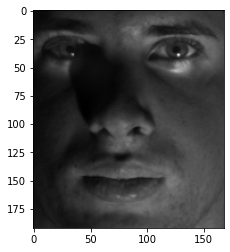

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


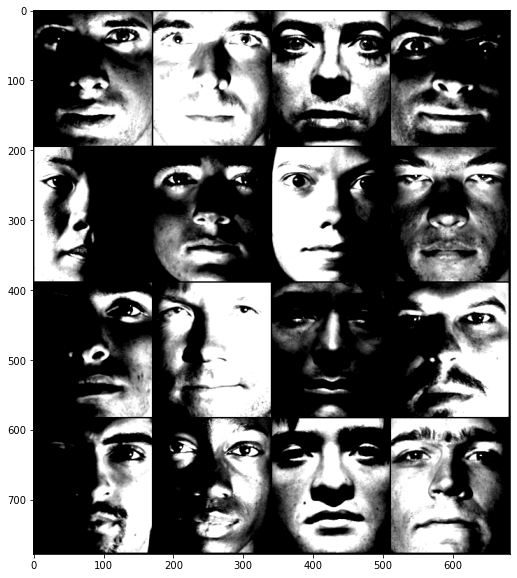

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
 
input = train_dataset[0][0].reshape(1, 1, 168, 192)
# 觀察 network 輸出結果
out = net(input.to(device))
print(out.to("cpu").detach().numpy().shape)
print(out.data)
print(out.data.max(1, keepdim=True)[1])
print(out.to("cpu").detach().numpy())
 
# get some random training images
dataiter = iter(train_loader) # an iterable object
images, labels = next(dataiter) # get the next batch
print(images.shape)
 
# show a single image
a_image = images[0]
a_image_ = np.transpose(a_image, (2, 1, 0))
plt.imshow(a_image_, cmap='gray')
plt.show()
 
# show a grid of images
montage = torchvision.utils.make_grid(images, nrow=4) # make a grid of images with 16 images per row
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(montage, (2, 1, 0)), cmap='gray')
plt.show()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net2.parameters(), lr = 0.01) 


# **訓練模型**
<h5>

1. 使用 epochs 參數設置訓練的迭代次數，每個 epoch 是對整個數據集進行一次完整的訓練。

2. 初始化 running_loss 變數，用於追蹤每個 epoch 的訓練損失。

3. 使用 enumerate(train_loader, 0) 遍歷訓練數據加載器 train_loader 中的數據，並獲取圖像 inputs 和標籤 labels。

4. 通過將圖像 inputs 傳遞到模型中進行前向傳播，獲取模型的預測結果 outputs。

5. 計算損失值 loss，使用損失函數 criterion 將模型的預測結果 outputs 與真實標籤 labels 進行比較。

6. 更新模型的權重，使用優化器 optimizer 來調整模型參數。

7. 追蹤並累加每個 mini-batch 的訓練損失，並在每經過 200 個 mini-batch 時打輸出平均損失。
</h5>

In [10]:
epochs = 20
for epoch in range(epochs):  # loop over the dataset multiple times
 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # move to GPU if available
     
        #print(data[1])
        #print(data[0])

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs) # forward pass

        loss = criterion(outputs, labels) # compute loss
        # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward() # compute gradients
        optimizer.step() # update weights
 
        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[epoch : {epoch + 1}, batch: {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
 
print('Finished Training')

Finished Training


In [13]:
PATH = './yelaFace_net.pt' # .pth will collide with the PyTorch JIT
torch.save(net.state_dict(), PATH)

# **測試資料正確率**

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
 
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 96 %


# **測試模型**
<h5>

首先，從 test_loader 中隨機選擇一個批次的圖像和標籤，這裡使用 torch.randint 函數生成一個隨機索引 sample_idx，然後使用 iter(test_loader) 創建一個可迭代對象 dataiter，並使用 next(dataiter) 獲取 sample_idx 對應的圖像和標籤。

接下來，將選擇的測試圖像以網格形式拼接並顯示出來，使用 torchvision.utils.make_grid 函數將圖像拼接成一個網格，並使用 plt.imshow 函數顯示圖像。這段程式碼用於檢視測試圖像的真實情況。

然後，使用選擇的測試圖像通過神經網路進行預測，將圖像傳遞給 net 模型並使用 net(images.to(device)) 得到預測結果 outputs。接著，使用 torch.max 函數從預測結果中找出具有最高能量的類別，並將預測結果 predicted 和真實標籤 labels 進行比較。
</h5>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


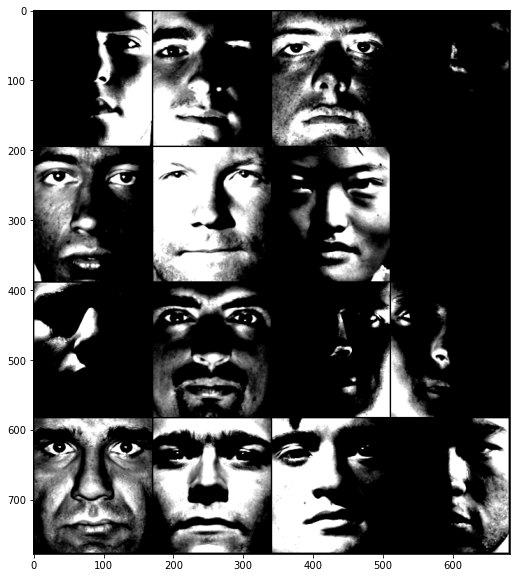

The predictions:
 {tensor([[24, 11, 24,  7],
        [37,  2,  8, 17],
        [28, 25,  3, 15],
        [ 3,  8, 33, 36]])}
Accuracy of the network on the 64 test images: 93.75 %


In [27]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
 
sample_idx = torch.randint(len(test_loader), size=(1,)).item()
dataiter = iter(test_loader)
for i in range(sample_idx): # randomly select a batch
    images, labels = next(dataiter)
 
# print test images
montage = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(montage, (2, 1, 0)), cmap='gray')
plt.show()
 
# predict the labels
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print("The predictions:\n", {predicted.reshape(batch_size // 4, 4)})
 
total = labels.size(0)
correct_rate = (predicted == labels.to(device)).sum().item() / total
print(f'Accuracy of the network on the 64 test images: {100 * correct_rate} %')

# **重新讀入 CNN 模型**

In [23]:
# Initialize the model.
model = Net().to(device)
checkpoint = torch.load('./yelaFace_net.pt')
model.load_state_dict(checkpoint)
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28080, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=38, bias=True)
)


# **輸入一張影像進行測試**

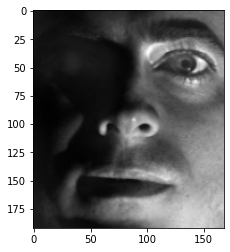

The predictions:
 {tensor(5)}


In [49]:
num = 190
one_image= test_dataset[num][0]
plt.imshow(np.transpose(one_image, (2, 1, 0)), cmap='gray')
plt.show()

one_input = one_image.reshape(1, 1, 168, 192)
one_out = net(one_input.to(device))
_, predicted = torch.max(one_out, 1)
print("The predictions:\n", {predicted[0]})

# **實驗結果**
<h5>

* 本次實驗中發現 batch_size = 16 (正確率: 96%) 的測試資料辨識正確率會高於 batch_size = 32(正確率:90%)，且在這兩個 batch_size 參數下，兩層卷基層搭配兩個全連接層的正確率會大於三個全連接層(正確率:84%)，在確定模型內容之後，發現隨著 epochs 數量增加(10、15、20)，正確率也會增加，因此對於此資料量足夠的資料集建議不需要要將模型複雜化，只需要增加神經元個數就可以了。

* 除了以上模型的架構外，也可以嘗試加入Projected Gradient Descent (PGD)，通過模型的迭代訓練，使其能夠抵抗對抗攻擊，提高模型的安全性和穩定性，並確保其在面對未知的敵對樣本時仍能產生可靠的預測結果。
</h5>